##  Import

In [1]:
import os
import matplotlib.pyplot as plt
import math
import numpy as np

## Hàm bổ trợ

In [2]:
def visualize_maze(matrix, bonus, start, end, route=None, visited=None, fig_size=(6.4, 4.8)):
    """
    Args:
      1. matrix: The matrix read from the input file,
      2. bonus: The array of bonus points,
      3. start, end: The starting and ending points,
      4. route: The route from the starting point to the ending one, defined by an array of (x, y), e.g. route = [(1, 2), (1, 3), (1, 4)]
    """
    #1. Define walls and array of direction based on the route
    walls=[(i,j) for i in range(len(matrix)) for j in range(len(matrix[0])) if matrix[i][j]=='x']

    if route:
        direction=[]
        for i in range(1,len(route)):
            if route[i][0]-route[i-1][0]>0:
                direction.append('v') #^
            elif route[i][0]-route[i-1][0]<0:
                direction.append('^') #v        
            elif route[i][1]-route[i-1][1]>0:
                direction.append('>')
            else:
                direction.append('<')

        direction.pop(0)

    #2. Drawing the map
    ax=plt.figure(dpi=100, figsize=fig_size).add_subplot(111)

    for i in ['top','bottom','right','left']:
        ax.spines[i].set_visible(False)

    plt.scatter([i[1] for i in walls],[-i[0] for i in walls],
                marker='X',s=100,color='black')
    
    plt.scatter([i[1] for i in bonus],[-i[0] for i in bonus],
                marker='P',s=100,color='green')

    plt.scatter(start[1],-start[0],marker='*',
                s=100,color='gold')
    
    if visited:
        plt.scatter([i[1] for i in visited],[-i[0] for i in visited],
                    marker='.',s=100,color='blue', alpha= 0.1)

    if route:
        for i in range(len(route)-2):
            plt.scatter(route[i+1][1],-route[i+1][0],
                        marker=direction[i],color='blue')

    plt.text(end[1],-end[0],'EXIT',color='red',
         horizontalalignment='center',
         verticalalignment='center')
    plt.xticks([])
    plt.yticks([])
    plt.show()

    print(f'Starting point (x, y) = {start[0], start[1]}')
    print(f'Ending point (x, y) = {end[0], end[1]}')
    
    for _, point in enumerate(bonus):
        print(f'Bonus point at position (x, y) = {point[0], point[1]} with point {point[2]}')

In [3]:
def read_file(file_name: str = 'maze.txt'):
  f=open(file_name,'r')
  n_bonus_points = int(next(f)[:-1])
  bonus_points = []
  for i in range(n_bonus_points):
    x, y, reward = map(int, next(f)[:-1].split(' '))
    bonus_points.append((x, y, reward))

  text=f.read()
  matrix=[list(i) for i in text.splitlines()]
  f.close()

  return bonus_points, matrix
  

In [4]:
def custom_sort(lst, bonus_points):
    '''lst: list of lists'''
    # first, sort by f 
    lst.sort(key = lambda item: item[1])
    # second, prioritise bonus points
    i = 0

    while i < len(lst):
        istart = i
        iend = -1
        for j in range(i+1, len(lst)):
            if lst[j][-1] != lst[i][-1]:
                iend = j
                break
        
        if istart < iend:
            itmp = istart
            for k in range(istart, iend):
                if lst[k][0] in bonus_points:
                    lst[itmp], lst[k] = lst[k], lst[itmp]
                    itmp += 1
            i = iend
        else:
            i += 1

## CLASS

In [5]:
class Node:
    def __init__(self, x: int, y: int, bonus=0):
        self.x = x 
        self.y = y
        self.bonus = bonus # bonus point (negative)
        self.next = [] # save adjacency nodes
        self.pos = -1 # ordinal number (positive)
        self.wall = False # check if the node is a wall 'x'

    def __repr__(self):
        neighbors = [(item.x, item.y) for item in self.next]
        return f'({self.x},{self.y}) -> {neighbors}'

class Maze:
    def __init__(self, matrix, bonus_points= []):
        self.height = len(matrix)
        self.width = len(matrix[0])
        self.V = 0 # no. of non-wall nodes
        self.graph = [] # adjacency list
        self.bonuses = [] # list of bonus nodes

        # make each item in the matrix be a node itself 
        graph = []
        for i in range(self.height):
            for j in range(self.width):
                if matrix[i][j] != 'x': # not wall
                    node = Node(i,j)
                    self.V += 1

                    if matrix[i][j] == '+':
                        node.bonus = [item[-1] for item in bonus_points if (item[0], item[1]) == (i, j)][0] # bonus line structure: <x y neg_score>
                        self.bonuses.append(node)
                    elif matrix[i][j] in ['S', 's', '*']: #detect start point
                        self.start = node 
                    elif i in [0,self.height-1] or j in [0,self.width-1]: #detect end point
                        self.end = node
                else: # wall
                    node = Node(-1,-1)
                    node.wall = True
                node.pos = i * self.width + j
                graph.append(node) 
        # sort bonus points based on their scores (ascending)
        self.bonuses.sort(key= lambda x: x.bonus)
              
        # create adj list
        for item in graph:
            if item.wall == False:
                x,y = item.x, item.y
                if x + 1 < self.height and matrix[x+1][y] != 'x':
                    item.next.append(graph[(x+1) * self.width + y])
                if matrix[x-1][y] != 'x':
                    item.next.append(graph[(x-1) * self.width + y])
                if y + 1 < self.width and matrix[x][y+1] != 'x': 
                    item.next.append(graph[x * self.width + y+1])
                if matrix[x][y-1] != 'x':
                    item.next.append(graph[x * self.width + y-1])
            self.graph.append(item)
    
    def print_graph(self):
        for node in self.graph:
            print(node)

# <font color=red>A. BẢN ĐỒ KHÔNG CÓ BONUS

## I. NHÓM THUẬT TOÁN TÌM KIẾM MÙ

### 1. BFS

In [6]:
def bfs(maze, start: Node, end: Node):
    queue = [start]
    vis = [start]
    node_init = Node(-2,-2)
    par = [node_init] * (maze.height * maze.width)

    while queue:
        v = queue.pop(0)

        if v == end:
            break
        for adj_node in v.next:
            if adj_node not in vis:
                queue.append(adj_node)
                vis.append(adj_node)
                par[adj_node.pos] = v 

    # construct a path
    path = [end]
    cur = end
    total_cost = 0
    
    while path[-1].pos != start.pos:
        if cur in maze.bonuses:
            total_cost += cur.bonus
        total_cost += 1
        parent = par[cur.pos]
        path.append(parent)
        cur = parent
        
    path.reverse()
    path = [(item.x, item.y) for item in path]
    vis = [(item.x, item.y) for item in vis]
    return path, vis, total_cost

### 2. DFS

In [7]:
def dfs(maze: Maze, start: Node, end: Node):
    stack = [start]
    vis = [start]
    node_init = Node(-2,-2)
    par = [node_init] * (maze.height * maze.width)

    while stack:
        v = stack.pop(0)

        if v.x == end.x and v.y == end.y:
            break
        for adj_node in v.next:
            i = 0

            if adj_node not in vis:
                stack.insert(i, adj_node)
                vis.append(adj_node)
                par[adj_node.pos] = v 
                i += 1
    
    # construct a path
    path = [end]
    cur = end
    total_cost = 0
    
    while path[-1].pos != start.pos:
        
        if cur in maze.bonuses:
            total_cost += cur.bonus
        total_cost += 1
        parent = par[cur.pos]
        path.append(parent)
        cur = parent
        
    path.reverse()
    path = [(item.x, item.y) for item in path]
    vis = [(item.x, item.y) for item in vis]
    return path, vis, total_cost        

## II. NHÓM THUẬT TOÁN TÌM KIẾM CÓ THÔNG TIN

### 1. Heuristic

In [8]:
def heuristic_euclid(maze: Maze, end: Node):
    heuristic = [float("inf")] * (maze.height*maze.width)
    for node in maze.graph:
        if not node.wall:
            heuristic[node.pos] = math.sqrt((node.x - end.x)**2 + (node.y - end.y)**2)
    return heuristic # list

def heuristic_manhattan(maze: Maze, end: Node):
    heuristic = [float("inf")] * (maze.height*maze.width)
    for node in maze.graph:
        if not node.wall:
            heuristic[node.pos] = abs(node.x - end.x) + abs(node.y - end.y)
    return heuristic   

### 2. A*

In [9]:
def a_star(maze: Maze, start: Node, end: Node, h):
    vis = [start]
    node_init = Node(float("inf"), float("inf"))
    par = [node_init] * (maze.height * maze.width)
    # g(n): weight from start node to node 'n' 
    g = [float("inf")] * (maze.height * maze.width)
    g[start.pos] = 0
    # f(n) = h(n) + g(n): evaluated function
    f = [float("inf")] * (maze.height * maze.width)
    f[start.pos] = h[start.pos]
    # open list (always sort in f-descending order)
    queue = [(start, f[start.pos])]

    while queue:
        queue.sort(key = lambda item: item[1]) # sort by f, f = h + g
        cur = queue.pop(0)[0]

        if cur.x == end.x and cur.y == end.y:
            break
        for neighbor in cur.next:
            d = 1 # d(cur, neighbor)
            if neighbor in vis:
                f_new = g[cur.pos] + d + h[neighbor.pos] # recalculate f[neighbor]
                if f_new < f[neighbor.pos]: # if a better path with smaller f is found
                    g[neighbor.pos] = g[cur.pos] + d
                    par[neighbor.pos] = cur
            else: # not visited
                vis.append(neighbor)
                g[neighbor.pos] = g[cur.pos] + d
                f[neighbor.pos] = g[neighbor.pos] + h[neighbor.pos]
                par[neighbor.pos] = cur
                if (neighbor, f[neighbor.pos]) not in queue:
                    queue.append((neighbor, f[neighbor.pos]))
                    
    # reconstruct a path
    total_cost = 0
    path = [end]
    cur = end
    # trace back
    while path[-1].pos != start.pos:
        if cur in maze.bonuses:
            total_cost += cur.bonus
        total_cost += 1
        parent = par[cur.pos]
        path.append(parent)
        cur = parent
        
    path.reverse()
    path = [(item.x, item.y) for item in path]
    vis = [(item.x, item.y) for item in vis]
    return path, vis, total_cost

### 3. Greedy best first search

In [10]:
def gbfs(maze: Maze, start: Node, end: Node, h):
    vis = [start]
    node_init = Node(float("inf"), float("inf"))
    par = [node_init] * (maze.height * maze.width)
    # f(n) = h(n)  evaluated function
    f = [float("inf")] * (maze.height * maze.width)
    f[start.pos] = h[start.pos]
    # open list - new added content will be ascending order (sort by height of heuristic)
    stack = [(start, f[start.pos])]

    while stack:
        cur = stack.pop(0)[0]

        newNeighbor = []

        if cur.x == end.x and cur.y == end.y:
            break
        for neighbor in cur.next:
            d = 1 # d(cur, neighbor)
            if neighbor in vis:
                f_new = d + h[neighbor.pos] # recalculate f[neighbor]
                if f_new < f[neighbor.pos]: # if a better path with smaller f is found
                    par[neighbor.pos] = cur
            else: # not visited
                vis.append(neighbor)
                f[neighbor.pos] = h[neighbor.pos]
                par[neighbor.pos] = cur
                if (neighbor, f[neighbor.pos]) not in stack:
                    newNeighbor.append((neighbor, f[neighbor.pos]))

        newNeighbor.sort(key = lambda item: item[1])
        
        i = 0
        for neighbor in newNeighbor:
            stack.insert(i, neighbor)
            i += 1
                    
    # construct a path
    path = [end]
    cur = end
    total_cost = 0
    
    while path[-1].pos != start.pos:
        
        if cur in maze.bonuses:
            total_cost += cur.bonus
        total_cost += 1
        parent = par[cur.pos]
        path.append(parent)
        cur = parent
        
    path.reverse()
    path = [(item.x, item.y) for item in path]
    vis = [(item.x, item.y) for item in vis]
    return path, vis, total_cost

### **Test các thuật toán với bản đồ không có điểm thưởng**
Trong cell dưới đây thầy chỉ cần điều chỉnh những biến sau là đủ:
- **Biến `x`**: quy định chỉ số (index) của file cần test
    - `x=1` tương ứng `map_no_bonus01.txt`
    - `x=2` tương ứng `map_no_bonus02.txt`
    - `x=3` tương ứng `map_no_bonus03.txt`
    - `x=4` tương ứng `map_no_bonus04.txt`
    - `x=5` tương ứng `map_no_bonus05.txt`
- **Biến `heuristic`** (dòng 11-14): điều chỉnh heuristic mong muốn của thầy. Mỗi lần chạy chỉ chấp nhận 1 heuristic. Giả sử nếu thầy muốn sử dụng euristic Manhattan thì chỉ để dòng 12 và comment dòng 13,14. 
    - <u>Lưu ý</u>: heuristic trong trường hợp map không có bonus thì biến `heuristic` chỉ chấp nhận hoặc là `heuristic_euclid`, hoặc là `heuristic_manhattan`; do đó thầy không nên gán thêm dòng `heuristic = manhattan_custom` vì hàm `manhattan_custom` chỉ dùng cho riêng trường hợp map có bonus
- **Biến `path`**: đường đi áp dụng thuật toán mong muốn của thầy. Mỗi lần chạy chỉ chấp nhận 1 path. Giả sử nếu thầy muốn chạy bfs thì chỉ để dòng 17 và comment dòng 18,19,20
- **Tham số `fig_size = (width, height)` của hàm visualize**: điều chỉnh kích cỡ hình mê cung. Với các mê cung dày đặc, thầy có thể cân nhắc nới rộng fig_size để dễ nhìn hơn. Em có comment 1 số fig_size hay dùng bên cạnh, thầy có thể cân nhắc copy 

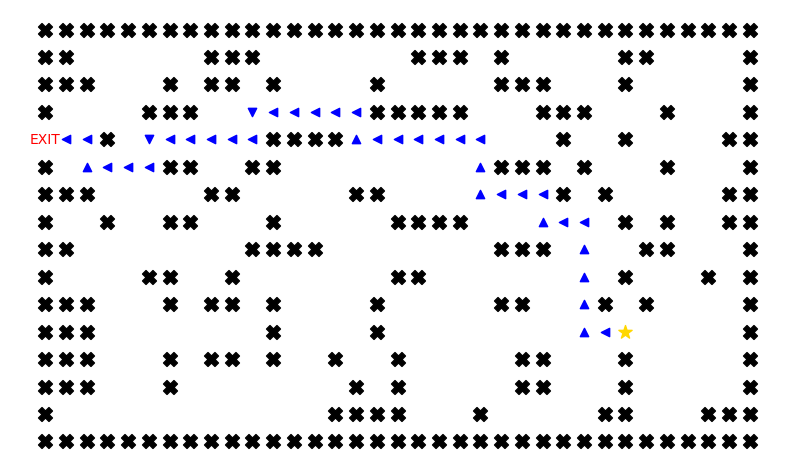

Starting point (x, y) = (11, 28)
Ending point (x, y) = (4, 0)
Total cost = 39


In [11]:
# biến x
x = 1
#----------------

file_path = f'./testcases/map_no_bonus0{x}.txt' 
bonus_points, matrix = read_file(file_path)
maze = Maze(matrix, bonus_points)
start = (maze.start.x, maze.start.y)
end = (maze.end.x, maze.end.y)

# biến heuristic
heuristic = heuristic_manhattan(maze, maze.end)
# heuristic = heuristic_euclid(maze, maze.end)
#----------------

# biến path
path = bfs(maze, maze.start, maze.end)
# path = dfs(maze, maze.start, maze.end)
# path = gbfs(maze, maze.start, maze.end, heuristic)
# path = a_star(maze, maze.start, maze.end, heuristic)
#----------------

visualize_maze(matrix, bonus_points, start, end, route= path[0], fig_size=(10,6)) #, (12,15), (10,6)
print(f'Total cost = {path[2]}')

# <font color=red>B. BẢN ĐỒ CÓ ĐIỂM THƯỞNG

## 1. Heuristic bổ sung

In [12]:
def dist(node1: Node, node2: Node):
    return math.sqrt((node1.x - node2.x)**2 + (node1.y - node2.y)**2)

# heuristic for bonus_map only                    
def manhattan_custom(maze: Maze, end: Node):
    h = [float("inf")] * (maze.height*maze.width)
    
    for node in maze.graph:
        if not node.wall:
            for bonus in maze.bonuses:
                closest_bonus = [(item, dist(node, item)) for item in maze.bonuses]
                closest_bonus.sort(key= lambda tup: tup[1])
                closest_bonus = closest_bonus[0][0]
                
                h_tmp = dist(node, closest_bonus) + closest_bonus.bonus + dist(closest_bonus, maze.end)
                expected_len = dist(node, end)
                h[node.pos] = min(h_tmp, expected_len)
    return h   

## 2. A*

In [13]:
def a_star_bonus(maze: Maze, start: Node, end: Node, h):
    node_init = Node(float("inf"), float("inf"))
    # parent list
    par = [node_init] * (maze.height * maze.width)
    # current node to traverse|
    cur = node_init
    # g(n): weight from start node to node 'n' 
    g = [float("inf")] * (maze.height * maze.width)
    g[start.pos] = 0
    # f(n) = h(n) + g(n): evaluated function
    f = [float("inf")] * (maze.height * maze.width)
    f[start.pos] = h[start.pos]
    # open list (always sort in f-descending order)
    queue = [[start, f[start.pos]]]
    # close list: save visited nodes
    vis = [start]
    # find const
    bonus_points = [abs(bonus_node.bonus) for bonus_node in maze.bonuses]
    # bonus_points.append(1)
    const = max(bonus_points) + 1
    
    while queue and cur != end:
        # queue.sort(key = lambda item: item[1]) # sort by f, f = h + g
        custom_sort(queue, maze.bonuses)
        cur = queue.pop(0)[0]
        
        for neighbor in cur.next:
            d = const + neighbor.bonus # tránh trọng số âm
            
            if neighbor in vis:
                f_new = g[cur.pos] + d + h[neighbor.pos] # recalculate f[neighbor]
                if f_new < f[neighbor.pos]: # if a better path with smaller f is found
                    g[neighbor.pos] = g[cur.pos] + d
                    par[neighbor.pos] = cur

            else: # not visited
                vis.append(neighbor)
                g[neighbor.pos] = g[cur.pos] + d
                f[neighbor.pos] = g[neighbor.pos] + h[neighbor.pos]
                par[neighbor.pos] = cur
                if [neighbor, f[neighbor.pos]] not in queue: 
                    queue.append([neighbor, f[neighbor.pos]])
        
    # reconstruct a path
    total_cost = 0
    path = [end]
    cur = end
    
    while path[-1].pos != start.pos:
        if cur in maze.bonuses:
            total_cost += cur.bonus
        total_cost += 1
        parent = par[cur.pos]
        path.append(parent)
        cur = parent
        
    path.reverse()
    path = [(item.x, item.y) for item in path]
    vis = [(item.x, item.y) for item in vis]
    return path, vis, total_cost	


## 3. Greedy Best First Search

In [14]:
def gbfs_bonus(maze: Maze, start: Node, end: Node, h):
    node_init = Node(float("inf"), float("inf"))
    par = [node_init] * (maze.height * maze.width)
    # f(n) = h(n): evaluated function
    f = [float("inf")] * (maze.height * maze.width)
    f[start.pos] = h[start.pos]
    # open list (always sort in f-descending order)
    stack = [[start, f[start.pos]]]
    # clost list: save visited nodes
    vis = [start]
    # find const
    bonus_points = [abs(bonus_node.bonus) for bonus_node in maze.bonuses]
    # bonus_points.append(1)
    const = max(bonus_points) + 1
    
    while stack:
        cur = stack.pop(0)[0]
        newNeighbor = []
        
        if (cur.x, cur.y) == (end.x, end.y):
            break
        
        for neighbor in cur.next:
            d = const + neighbor.bonus # tránh trọng số âm
                    
            if neighbor in vis:
                f_new = d + h[neighbor.pos] 

            else: # not visited
                vis.append(neighbor)
                f[neighbor.pos] = h[neighbor.pos] + d
                par[neighbor.pos] = cur
                if (neighbor, f[neighbor.pos]) not in stack:
                    newNeighbor.append((neighbor, f[neighbor.pos]))

        custom_sort(newNeighbor, maze.bonuses)
        
        i = 0
        for neighbor in newNeighbor:
            stack.insert(i, neighbor)
            i += 1
    
    # reconstruct a path
    total_cost = 0
    path = [end]
    cur = end
    
    while path[-1].pos != start.pos:
        if cur in maze.bonuses:
            total_cost += cur.bonus
        total_cost += 1
        parent = par[cur.pos]
        path.append(parent)
        cur = parent
        
    path.reverse()
    path = [(item.x, item.y) for item in path]
    vis = [(item.x, item.y) for item in vis]
    return path, vis, total_cost

### **Test các thuật toán với bản đồ không có điểm thưởng**
Trong cell dưới đây thầy chỉ cần điều chỉnh những biến sau là đủ:
- **Biến `x`**: quy định chỉ số (index) của file cần test
    - `x=1` tương ứng `map_bonus01.txt`
    - `x=2` tương ứng `map_bonus02.txt`
    - `x=3` tương ứng `map_bonus03.txt`
- **Biến `heuristic`** (dòng 11-15): điều chỉnh heuristic mong muốn của thầy. Mỗi lần chạy chỉ chấp nhận 1 heuristic. Giả sử nếu thầy muốn sử dụng euristic Manhattan thì chỉ để dòng 12 và comment dòng 13,14
- **Biến `path`** (dòng 17-20): đường đi áp dụng thuật toán mong muốn của thầy. Mỗi lần chạy chỉ chấp nhận 1 path. Giả sử nếu thầy muốn chạy A* thì chỉ để dòng 18 và comment dòng 19
- **Tham số `fig_size = (width, height)` của hàm visualize**: điều chỉnh kích cỡ hình mê cung. Với các mê cung dày đặc, thầy có thể cân nhắc nới rộng fig_size để dễ nhìn hơn. Em có comment 1 số fig_size hay dùng bên cạnh, thầy có thể cân nhắc copy 

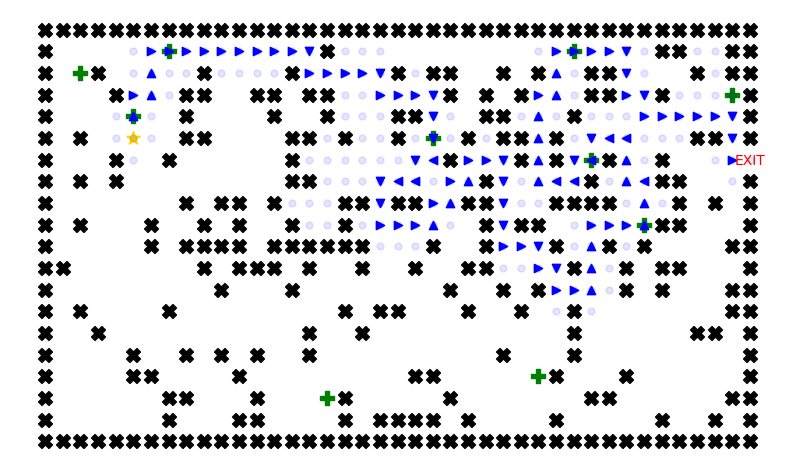

Starting point (x, y) = (5, 5)
Ending point (x, y) = (6, 40)
Bonus point at position (x, y) = (4, 5) with point -2
Bonus point at position (x, y) = (1, 7) with point -4
Bonus point at position (x, y) = (9, 34) with point -6
Bonus point at position (x, y) = (2, 2) with point -6
Bonus point at position (x, y) = (16, 28) with point -3
Bonus point at position (x, y) = (17, 16) with point -2
Bonus point at position (x, y) = (6, 31) with point -5
Bonus point at position (x, y) = (5, 22) with point -30
Bonus point at position (x, y) = (3, 39) with point -25
Bonus point at position (x, y) = (1, 30) with point -10
Total cost = 37


In [15]:
# biến x
x = 1
#------------

file_path = f'./testcases/map_bonus0{x}.txt' 
bonus_points, matrix = read_file(file_path)
maze = Maze(matrix, bonus_points)
start = (maze.start.x, maze.start.y)
end = (maze.end.x, maze.end.y)

# biến heuristic
# heuristic = heuristic_manhattan(maze, maze.end)
heuristic = manhattan_custom(maze, maze.end)
# heuristic = heuristic_euclid(maze, maze.end)
#------------

# biến path
# path = a_star_bonus(maze, maze.start, maze.end, heuristic)
path = gbfs_bonus(maze, maze.start, maze.end, heuristic)
#------------

visualize_maze(matrix, bonus_points, start, end, path[0], path[1], fig_size=(10,6)) #, (12,15), (10,6)
print(f'Total cost = {path[2]}')